In [1]:
!pip install torch

🔧 Testing basic functionality...
✅ Model creation: SUCCESS
✅ Custom optimizer: SUCCESS
✅ Image transforms: SUCCESS
🎉 All basic tests passed!

Ready to run main training!
Update the file paths in main() and run again.
🚀 SOIL CLASSIFICATION COMPETITION - ULTRA MINIMAL VERSION
1. Loading competition data...
Training CSV shape: (1222, 2)
Training classes distribution:
soil_type
Alluvial soil    528
Red soil         264
Black Soil       231
Clay soil        199
Name: count, dtype: int64
Test CSV shape: (341, 1)
Class mapping: {0: 'Alluvial soil', 1: 'Black Soil', 2: 'Clay soil', 3: 'Red soil'}
Found 1214 training images
Found 341 test images

2. Creating data loaders...
Training samples: 971
Validation samples: 243

3. Initializing model...
Model parameters: 32,804

4. Training model...
Training on device: cpu
Using custom optimizer with learning rate: 0.01
------------------------------------------------------------
Epoch [1/15]
  Batch [0/122], Loss: 1.3384
  Batch [20/122], Loss: 1.2487


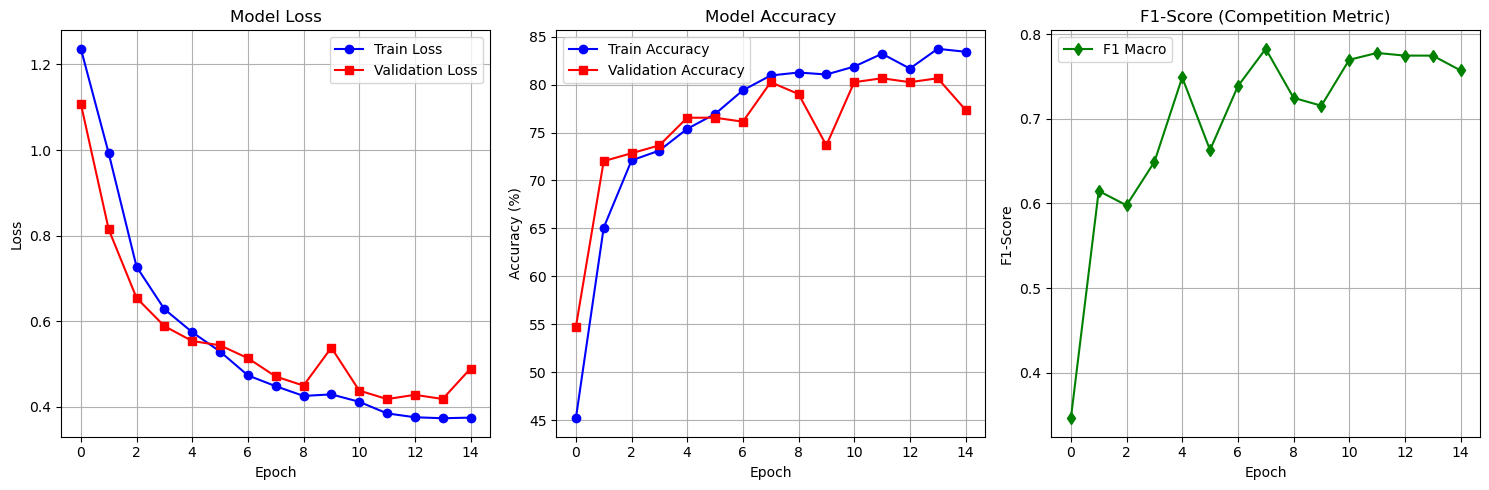


6. Evaluating model...
CLASSIFICATION REPORT
               precision    recall  f1-score   support

Alluvial soil       0.77      0.84      0.80       105
   Black Soil       0.89      0.89      0.89        46
    Clay soil       0.45      0.50      0.48        40
     Red soil       1.00      0.75      0.86        52

     accuracy                           0.77       243
    macro avg       0.78      0.74      0.76       243
 weighted avg       0.79      0.77      0.78       243


🎯 F1-Score (Macro): 0.7571 <- COMPETITION METRIC

7. Generating test predictions...
Generating test predictions...
Processed batch 0/43
Processed batch 10/43
Processed batch 20/43
Processed batch 30/43
Processed batch 40/43

Test predictions distribution:
soil_type
Black Soil       108
Red soil          94
Clay soil         78
Alluvial soil     61
Name: count, dtype: int64

8. Saving results...

🎉 TRAINING COMPLETED!
🎯 Final F1-Score (Competition Metric): 0.7571
📁 Files saved:
   - soil_classifier_final.p

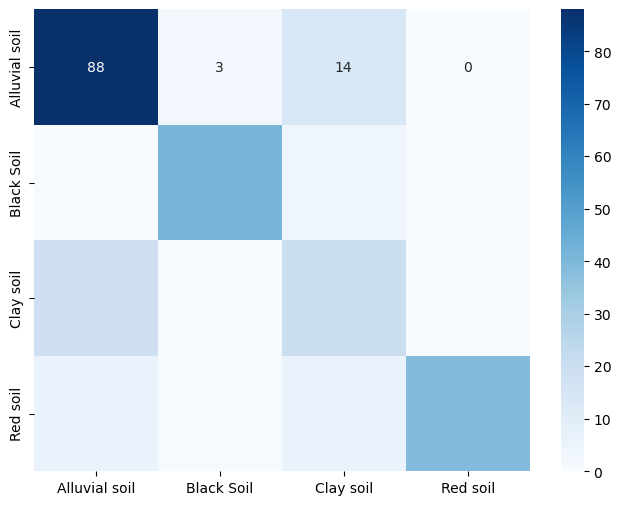

In [2]:
# Soil Classification Competition - Ultra Minimal Version
# Multi-class classification: Alluvial, Black, Clay, Red soil
# Compatible with older PyTorch versions

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

class SoilDataset(Dataset):
    """Custom Dataset class for soil images"""
    
    def __init__(self, image_paths, labels=None, transform=None, is_test=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        try:
            image = cv2.imread(image_path)
            if image is None:
                image = np.array(Image.open(image_path).convert('RGB'))
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return image, label

def load_competition_data(train_dir, test_dir, train_csv_path, test_csv_path):
    """Load competition data from CSV files and image directories"""
    
    # Load training data
    train_df = pd.read_csv(train_csv_path)
    print(f"Training CSV shape: {train_df.shape}")
    print(f"Training classes distribution:")
    print(train_df['soil_type'].value_counts())
    
    # Load test data
    test_df = pd.read_csv(test_csv_path)
    print(f"Test CSV shape: {test_df.shape}")
    
    # Label encoding
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(train_df['soil_type'])
    class_names = label_encoder.classes_
    
    print(f"Class mapping: {dict(zip(range(len(class_names)), class_names))}")
    
    # Create full paths for training images
    train_image_paths = []
    train_labels = []
    
    for idx, row in train_df.iterrows():
        img_path = os.path.join(train_dir, str(row['image_id']))
        # Try different extensions
        for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
            full_path = img_path + ext if not img_path.endswith(ext) else img_path
            if os.path.exists(full_path):
                train_image_paths.append(full_path)
                train_labels.append(encoded_labels[idx])
                break
    
    # Create full paths for test images
    test_image_paths = []
    test_image_ids = []
    
    for idx, row in test_df.iterrows():
        img_path = os.path.join(test_dir, str(row['image_id']))
        # Try different extensions
        for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG','.webp','.gif']:
            full_path = img_path + ext if not img_path.endswith(ext) else img_path
            if os.path.exists(full_path):
                test_image_paths.append(full_path)
                test_image_ids.append(row['image_id'])
                break
    
    print(f"Found {len(train_image_paths)} training images")
    print(f"Found {len(test_image_paths)} test images")
    
    return (train_image_paths, train_labels, test_image_paths, 
            test_image_ids, label_encoder, class_names)

# =============================================================================
# 2. SIMPLE TRANSFORMS
# =============================================================================

class SimpleTransform:
    """Simple image transforms without external dependencies"""
    
    def __init__(self, size=224, is_training=True):
        self.size = size
        self.is_training = is_training
    
    def __call__(self, image):
        # Resize image
        image = cv2.resize(image, (self.size, self.size))
        
        # Data augmentation for training
        if self.is_training:
            # Random horizontal flip
            if np.random.random() > 0.5:
                image = cv2.flip(image, 1)
            
            # Random brightness adjustment
            if np.random.random() > 0.7:
                brightness = np.random.uniform(0.8, 1.2)
                image = np.clip(image * brightness, 0, 255)
        
        # Convert to tensor and normalize
        image = image.astype(np.float32) / 255.0
        # Simple normalization
        image = (image - 0.5) / 0.5  # Scale to [-1, 1]
        
        # Convert to PyTorch tensor (HWC to CHW)
        image = torch.from_numpy(image.transpose(2, 0, 1))
        return image

def create_data_loaders(train_paths, train_labels, batch_size=8, val_split=0.2):
    """Create training and validation data loaders"""
    
    # Stratified split
    X_train, X_val, y_train, y_val = train_test_split(
        train_paths, train_labels, test_size=val_split, 
        stratify=train_labels, random_state=42
    )
    
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    
    # Create transforms
    train_transform = SimpleTransform(size=224, is_training=True)
    val_transform = SimpleTransform(size=224, is_training=False)
    
    # Create datasets
    train_dataset = SoilDataset(X_train, y_train, train_transform)
    val_dataset = SoilDataset(X_val, y_val, val_transform)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# =============================================================================
# 3. SIMPLE CNN MODEL
# =============================================================================

class SoilCNN(nn.Module):
    """Simple CNN for soil classification"""
    
    def __init__(self, num_classes=4):
        super(SoilCNN, self).__init__()
        
        # Simple convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(4, 4)  # 224 -> 56
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(4, 4)  # 56 -> 14
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 14 -> 7
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Simple classifier
        self.fc = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # Feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.fc(x)
        return x

# =============================================================================
# 4. CUSTOM SIMPLE OPTIMIZER
# =============================================================================

class SimpleOptimizer:
    """Custom simple SGD optimizer to avoid PyTorch compatibility issues"""
    
    def __init__(self, parameters, lr=0.01):
        self.parameters = list(parameters)
        self.lr = lr
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.data.zero_()
    
    def step(self):
        for param in self.parameters:
            if param.grad is not None:
                param.data -= self.lr * param.grad.data

# =============================================================================
# 5. TRAINING FUNCTIONS
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if batch_idx % 20 == 0:
            print(f'  Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate model for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_acc, f1_macro, all_preds, all_labels

def train_model_custom(model, train_loader, val_loader, class_names, num_epochs=15, learning_rate=0.01):
    """Training loop with custom optimizer"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    # Use custom optimizer
    optimizer = SimpleOptimizer(model.parameters(), lr=learning_rate)
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1_macro': []
    }
    
    best_f1 = 0.0
    best_model_state = None
    
    print(f"Training on device: {device}")
    print(f"Using custom optimizer with learning rate: {learning_rate}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        
        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_acc, val_f1_macro, _, _ = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Save best model
        if val_f1_macro > best_f1:
            best_f1 = val_f1_macro
            best_model_state = model.state_dict().copy()
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1_macro'].append(val_f1_macro)
        
        # Print progress
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Val F1 Macro: {val_f1_macro:.4f}')
        print("-" * 60)
        
        # Simple learning rate decay
        if epoch > 0 and epoch % 5 == 0:
            optimizer.lr *= 0.5
            print(f"Learning rate reduced to: {optimizer.lr:.6f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f'Best Validation F1-Score (Macro): {best_f1:.4f}')
    
    return model, history

# =============================================================================
# 6. EVALUATION AND VISUALIZATION
# =============================================================================

def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train Loss', color='blue', marker='o')
    axes[0].plot(history['val_loss'], label='Validation Loss', color='red', marker='s')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train Accuracy', color='blue', marker='o')
    axes[1].plot(history['val_acc'], label='Validation Accuracy', color='red', marker='s')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].legend()
    axes[1].grid(True)
    
    # F1 Score plot
    axes[2].plot(history['val_f1_macro'], label='F1 Macro', color='green', marker='d')
    axes[2].set_title('F1-Score (Competition Metric)')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1-Score')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, val_loader, class_names):
    """Comprehensive model evaluation"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Get predictions
    _, _, f1_macro, predictions, true_labels = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Classification report
    print("=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(true_labels, predictions, target_names=class_names))
    
    print(f"\n🎯 F1-Score (Macro): {f1_macro:.4f} <- COMPETITION METRIC")
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    # # Annotate manually with contrasting colors
    # for i in range(cm.shape[0]):
    #     for j in range(cm.shape[1]):
    #         value = cm[i, j]
    #         text_color = "white" if cm[i, j] > cm.max() / 2 else "black"
    #         ax.text(j + 0.5, i + 0.5, str(value),
    #         ha="center", va="center", color=text_color)
    
    # plt.title('Confusion Matrix')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()

    return f1_macro

def create_test_predictions(model, test_image_paths, test_image_ids, label_encoder):
    """Generate predictions for test set"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    test_transform = SimpleTransform(size=224, is_training=False)
    test_dataset = SoilDataset(test_image_paths, labels=None, transform=test_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    predictions = []
    
    print("Generating test predictions...")
    with torch.no_grad():
        for batch_idx, images in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            
            if batch_idx % 10 == 0:
                print(f"Processed batch {batch_idx}/{len(test_loader)}")
    
    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'image_id': test_image_ids,
        'soil_type': predicted_labels
    })
    
    print(f"\nTest predictions distribution:")
    print(submission_df['soil_type'].value_counts())
    
    return submission_df

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""
    
    print("🚀 SOIL CLASSIFICATION COMPETITION - ULTRA MINIMAL VERSION")
    print("=" * 70)
    
    # Configuration - UPDATE THESE PATHS
    TRAIN_DIR = "train"
    TEST_DIR = "test"
    TRAIN_CSV ="train_labels.csv"
    TEST_CSV = "test_ids.csv"
    
    BATCH_SIZE = 8   # Very small batch size for compatibility
    NUM_EPOCHS = 15
    LEARNING_RATE = 0.01
    
    print("1. Loading competition data...")
    train_paths, train_labels, test_paths, test_ids, label_encoder, class_names = load_competition_data(
        TRAIN_DIR, TEST_DIR, TRAIN_CSV, TEST_CSV
    )
    
    print("\n2. Creating data loaders...")
    train_loader, val_loader = create_data_loaders(train_paths, train_labels, BATCH_SIZE)
    
    print("\n3. Initializing model...")
    model = SoilCNN(num_classes=4)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    print("\n4. Training model...")
    trained_model, history = train_model_custom(
        model, train_loader, val_loader, class_names, NUM_EPOCHS, LEARNING_RATE
    )
    
    print("\n5. Plotting training history...")
    plot_training_history(history)
    
    print("\n6. Evaluating model...")
    final_f1 = evaluate_model(trained_model, val_loader, class_names)
    
    print("\n7. Generating test predictions...")
    submission_df = create_test_predictions(trained_model, test_paths, test_ids, label_encoder)
    
    print("\n8. Saving results...")
    torch.save(trained_model.state_dict(), 'soil_classifier_final.pth')
    submission_df.to_csv('submission.csv', index=False)
    
    print("\n" + "=" * 70)
    print("🎉 TRAINING COMPLETED!")
    print(f"🎯 Final F1-Score (Competition Metric): {final_f1:.4f}")
    print("📁 Files saved:")
    print("   - soil_classifier_final.pth (model)")
    print("   - submission.csv (competition submission)")
    print("=" * 70)

# Quick test function
def quick_test():
    """Quick test to verify everything works"""
    print("🔧 Testing basic functionality...")
    
    # Test model creation
    try:
        model = SoilCNN(num_classes=4)
        print("✅ Model creation: SUCCESS")
    except Exception as e:
        print(f"❌ Model creation: FAILED - {e}")
        return False
    
    # Test optimizer
    try:
        optimizer = SimpleOptimizer(model.parameters(), lr=0.01)
        print("✅ Custom optimizer: SUCCESS")
    except Exception as e:
        print(f"❌ Custom optimizer: FAILED - {e}")
        return False
    
    # Test transforms
    try:
        transform = SimpleTransform(size=224, is_training=True)
        dummy_image = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        transformed = transform(dummy_image)
        print("✅ Image transforms: SUCCESS")
    except Exception as e:
        print(f"❌ Image transforms: FAILED - {e}")
        return False
    
    print("🎉 All basic tests passed!")
    return True

if __name__ == "__main__":
    # Run quick test first
    if quick_test():
        print("\n" + "="*50)
        print("Ready to run main training!")
        print("Update the file paths in main() and run again.")
        print("="*50)
        
        # Uncomment to run full training
        main()
    else:
        print("❌ Basic tests failed. Check your PyTorch installation.")